## Install the package

In [1]:
!python -m pip install 'git+https://github.com/grosed/changed/#egg=changed&subdirectory=python/package'

  Cloning https://github.com/grosed/changed/ to /tmp/pip-install-6y9gyygb/changed_b8b88d9104704fe49be834cdc01b283b
  Running command git clone --filter=blob:none --quiet https://github.com/grosed/changed/ /tmp/pip-install-6y9gyygb/changed_b8b88d9104704fe49be834cdc01b283b
  Resolved https://github.com/grosed/changed/ to commit 4fd476fcc8b0fd16d59bbd087211f5bb288ed2ed
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


## Generate some test data

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm,median_abs_deviation,chi2

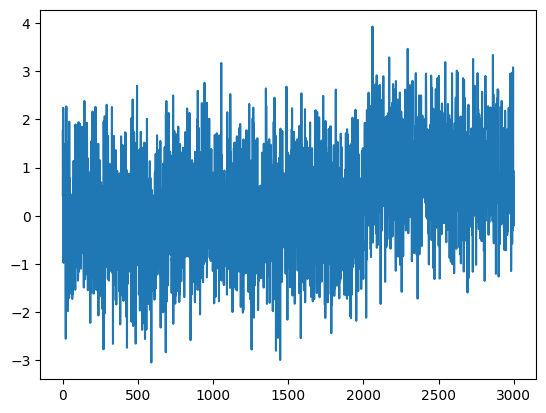

In [3]:
np.random.seed(0)
X = [0.0 for i in range(2000)] + [1.0 for i in range(1000)]
E = norm.rvs(size=len(X))
X = [x+e for x,e in zip(X,E)]
plt.plot(X)
plt.show()

## Initialise a cost function

In [4]:
from changed.cost.normal import mean as nm

In [5]:
cf = nm(X)

## Find the minumum of the cost function across the whole interval

In [6]:
from changed.core import split

In [7]:
R = list(range(len(X)))
split(cf,cf,R)

(2002, 2819.4281452840214)

## Run "At Most One Changepoint" (AMOC)

In [8]:
from changed.methods import amoc
from math import log

In [9]:
beta = 2*log(len(X))
amoc(cf,R,beta)

(2002, 2835.4408804193217)

## Present all of the data to a sequential implementation of optimal partitioning

In [10]:
from changed.methods.sequential import sop,sop_state

In [11]:
S = sop_state()
S = sop(S,cf,R,beta)

In [12]:
S.s(2999)

(2002, 2831.7864072636194)

## Loop over the data using a sequential implementation of optimal partitioning

In [13]:
S = sop_state()
for r in R :
    S = sop(S,cf,[r],beta)

In [14]:
S.s(2999)

(2002, 2831.7864072636194)

## Implement a sequential version of the cost function

In [15]:
from itertools import accumulate
from math import inf

class smean :
    def __init__(self,minseglen=0) :
        self.SX = [0]
        self.SXX = [0]
        self.minseglen = minseglen
    def __call__(self,a,b) :
        if b - a + 1 < self.minseglen :
            return inf
        val = self.SX[b+1] - self.SX[a]
        val *= val
        val /= (b - a + 1)
        val = -val
        val += self.SXX[b+1] - self.SXX[a]
        return val
    def add(self,X) :
        for x in X :
            self.SX.append(self.SX[-1] + x)
            self.SXX.append(self.SXX[-1] + x*x)
        

## Use sequential optimal partitioning with a sequential cost function

In [16]:
h = smean()
S = sop_state()
for r in list(range(len(X))) :
    h.add([X[r]])
    S = sop(S,h,[r],beta)
    

In [17]:
S.s(2999)

(2002, 2831.7864072636194)

## Use an offline interface to optimal partitioning

In [18]:
from changed.methods import op

In [19]:
res = op(cf,R,beta)

In [20]:
res(2999)

(2002, 2831.7864072636194)

## Implement capa  for detecting collective changes in mean using sequential optimal partitioning 

In [21]:
from changed.cost.normal import mean as nm
from changed.core import point_function

def capa_normal_mean(X,beta,beta_dash,minseglen=0) :
    S = sop_state()
    g = nm(X,minseglen)
    R = list(range(len(X)))
    C = lambda i : 0 if i < 0 else S.s(i)[1]
    C1 = lambda i : C(i)
    C2 = lambda i : C(i-1) + X[i]*X[i]
    C3 = lambda i : C(i-1) + beta_dash 
    anoms = point_function()
    for r in R :
        S = sop(S,g,[r],beta)
        cs = [C1(r),C2(r),C3(r)]
        c = min(cs)
        t = cs.index(c) + 1
        match t :
            case 1 :
                 anoms.union({(r,(S.s(r)[0],S.s(r)[1],1))})
            case 2 :
                S.s.union({(r,(S.s(r)[0],C2(r)))})
            case 3 :
                S.s.union({(r,(S.s(r)[0],C3(r)))})
                anoms.union({(r,(r,C3(r),3))}) 
    return anoms

### test data similar in structure to that in JSS anomaly paper

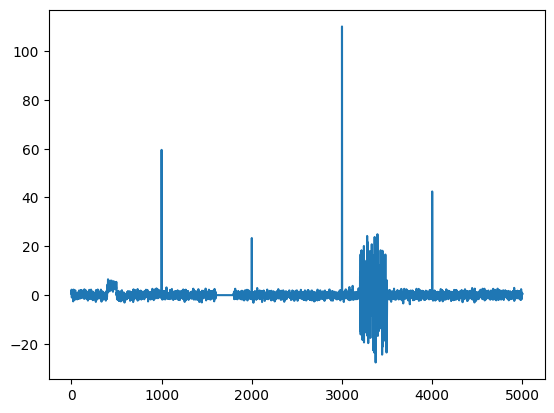

In [22]:
from statistics import median
from scipy.stats import median_abs_deviation
np.random.seed(0)
X = list(norm.rvs(size=5000,loc=0.0,scale=1.0))
X[400:500] = list(norm.rvs(size=100,loc=4.0,scale=1.0))
X[1600:1800] = list(norm.rvs(size=200,loc=0.0,scale=0.01))
X[3200:3500] = list(norm.rvs(size=300,loc=0.0,scale=10))
X[1000] = float(norm.rvs(size=1,loc=0.0,scale=100))
X[2000] = float(norm.rvs(size=1,loc=0.0,scale=100))
X[3000] = float(norm.rvs(size=1,loc=0.0,scale=100))
X[4000] = float(norm.rvs(size=1,loc=0.0,scale=100))

#mu = mean(X)
#mu =  median(X)
#sigma = sqrt(variance(Z)) # median_abs_deviation(Z)
#sigma = 1.4826*median_abs_deviation(X) # median_abs_deviation(Z)
#X = [(x-mu)/sigma for x in X] # normalise the data
plt.plot(X)
plt.show()

In [25]:
beta =  4*log(len(X))
beta_dash = 3*log(len(X))
res = capa_normal_mean(X,beta,beta_dash)
print("done")

done


In [24]:
for i in res.domain() :
    print(i,res(i))

0 (0, 0.0, 1)
1 (1, 5.551115123125783e-17, 1)
2 (1, 0.16737785702709174, 1)
3 (1, 1.7720334963333313, 1)
4 (1, 2.099686431209645, 1)
403 (401, 421.9524256151022, 1)
404 (401, 422.2731807215062, 1)
405 (401, 425.26368786013376, 1)
406 (400, 433.2959647530268, 1)
407 (400, 434.40860381926825, 1)
408 (400, 434.49205469223966, 1)
409 (400, 434.49264391948276, 1)
410 (400, 435.7164260519503, 1)
411 (400, 436.16568217482643, 1)
412 (400, 436.1735157891209, 1)
414 (400, 441.6857792925108, 1)
415 (400, 441.829678144284, 1)
416 (400, 442.4911505908787, 1)
417 (400, 442.84823503571187, 1)
418 (400, 443.4627629488584, 1)
419 (400, 443.5647757616214, 1)
420 (400, 447.32681892915457, 1)
421 (400, 448.3632526628765, 1)
422 (400, 451.9571053779172, 1)
424 (400, 456.917287728781, 1)
425 (400, 458.81951051060105, 1)
426 (400, 458.96343416259083, 1)
427 (400, 459.65264052134063, 1)
428 (400, 459.66374188788876, 1)
429 (400, 459.81112303446474, 1)
430 (400, 461.63153512391466, 1)
431 (400, 465.9717944403